An Expectation-Maximization Algorithm for Disentangling Blended YSOs
====================================

Generalities
--------------

The expectation-maximization (EM) algorithm is an optimization algorithm for parameter estimation based on a modified version of likelihood maximization for incomplete datasets. It was first described in 1977 in [this paper](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.133.4884) by Dempster, Laird and Rubin. A simple and illustrative tutorial to understand its basics can be found [here](http://nipunbatra.github.io/2014/04/em/). 

The method deals with the parameter estimation problem when incomplete or latent datasets are involved. In this context, "latent" refers to unknown portions of a given dataset. For example, in the case of the coin-flipping experiment described in the Nature paper, the latent variables are the identities of each of the coin used in each toss. For each of these two coins, you are attempting to estimate the probability of landing heads.

The EM algorithm involves two steps. In the first step (expectation) you start with initial guesses for the model parameters, and assuming those guesses to be the right values, you evaluate how likely it is to have obtained your data given those values of the parameters. In other words, you construct a probability density function for all possible completions of your dataset. In the second step (maximization), you maximize the resulting joint likelihood function to find new values for the parameters that you are attempting to estimate. Once this single two-step EM procedure has been performed, you iterate starting from the last obtained parameter values until you reach a convergence criterium. That's it.

The problem of blended YSOs
------------------------------

When attempting to derive the properties of young stellar objects (YSOs) that are part of a cluster -and in general of any clustered astronomical source- via spectral energy distribution (SED) modelling, one common problem is the lack of uniform spatial resolution accross all the observing bands. Since spatial resolution is wavelength dependent, the consequence of this is that sources that can be resolved in some bands (usually the optical and near-infrared bands), appear blended together within the point-spread function of ibservations performed at longher wavelengths (usually mid- and far-infrared). This means that for a particular ensemble of sources, it is very difficult to establish the contribution to the measured far-infrared flux from each of the individual sources that can be resolved at shorter wavelengths. And this, of course, jeopardizes any attempt to estimate those properties of the sources that are constrained only at far-infrared wavelengths (dust mass or total infrared luminosity, for example). The problem is illustrated in the following figure, where an ensemble of sources is seen in a K-band image (left) and at 24 microns with Spitzer (right).

![My figure](ds9_cluster.jpg)

This is a typical parameter estimation problem with incomplete datasets. In this case, the parameters to be estimated correspond to those parameters of whatever YSO model you are using (here we will use the Robitaille & Withney radiative transfer mode grid). The dataset corresponds to the fluxes of resolved and unresolved sources in each of the observing bands, whereas the latent data would be the contributions from each of the sources resolved in the short-wavelength bands to the total fluxes in the unresolved bands. Of course, you have to impose the additional constrain that the sum of all contributions from resolved sources has to correspond to the observed flux in the unresolved bands.

![My figure1](im3.png)

Starting with initial guesses for the model parameters for each resolved source, we therefore only need to construct likelihood probabability functions for all possible completions of the data, normalize those likelihoods and weight them according to the observed fluxes in unresolved bands, and then maximize the resulting joint probability to obtain updated values for the parameters. After enough iterations we should arrive at the solution that maximizes the likelihood for our incomplete dataset (and hence, we should end up with full SEDs for each of our resolved sources, including the bands in which they are not resolved). Here we describe a method to do so.


The likelihood function
--------------------------

We start by defining the likelihood function. In the case of an SED model $M$ that depends on the set of $m$ parameters $\{\theta_0,\ldots,\theta_m\}$ being adjusted to a set of data points with fluxes $D = \{F_i\}$ in bands $i, \ldots,n$ and associated uncertainties $\{\sigma_i\}$, if these observational uncertainties are distributed according to a Gaussian, the likelihood function can be derived from the $\chi^2$ distribution. The latter is the distribution of values:

$$\{\chi^2_{\rm{red}}(\theta_0,\ldots,\theta_m)\} = \frac{1}{n}\sum_i^n\frac{(F_i - M_i)^2}{\sigma_i}$$

evaluated for all possible values of the model parameters $\{\theta_0,\ldots,\theta_m\}$. The likelihood can in turn be expressed as:

$$\mathcal{L}(D|\theta_0,\ldots,\theta_m) \propto \exp\{-\chi^2_{\rm{red}}(\theta_0,\ldots,\theta_m)/2\}$$

Where the proportionality is due to the fact the the probability needs to be normalized according to the distribution of parameters. The reason why the errors must be Gaussian is that only in that case the $\mathcal{L}$ can be expresed as the product of individual Gaussians whose exponential terms are the values of $\chi^2{\rm{red}}$. We construct a probability function that takes the observed fluxes and uncertainties across bands, the model predicted photometry, and returns the likelihood and $\chi^2$ value.



In [3]:
# Import libraries

%pylab inline

import numpy as np
import scipy.io
from astropy.io import ascii
from astropy.table import Table, Column
from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import pickle

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Construct likelihood function

#========================================================================
#This function calculates the likelihood function for a given
#model and photometry dataset. And returns the lilekihood and chi^2.

#CALLING SEQUENCE
# > likelihood(fluxes, errors, weight)
# fluxes: The model fluxes at the wavelengths given by 'wave'
# errors: The associated errors
# weight: The weight to be given to each datapoint (uniform, etc.)
#========================================================================

def likelihood(obs_fluxes,obs_errors,model_fluxes,weight):
    
    # Remove no-data points
    zeros_index = where(obs_fluxes == 0.0)
    obs_fluxes = np.delete(obs_fluxes,zeros_index)
    obs_errors = np.delete(obs_errors,zeros_index)
    model_fluxes = np.delete(model_fluxes,zeros_index)
    
    # Number of datapoints
    n_data = len(obs_fluxes) 
    
    # Unbiased flux in log space (since we are fitting in logarithmic space, see Robitaille et al. 2007)
    log_obs_flux = log10(obs_fluxes) - 0.5*(1.0/log(10.))*(1.0/(obs_fluxes**2.0))*obs_errors*obs_errors 
    
    # Unbiased variances in log space (since we are fitting in logarithmic space, see Robitaille et al. 2007)
    log_obs_var2 = (((1.0/log(10.))*(1.0/obs_fluxes))**2.0)*obs_errors*obs_errors 
    
    # Model flux in log space
    log_mod_flux = log10(model_fluxes) 
    
    # Reduced chi^2
    chi_squared = (1.0/n_data)*sum(((log_obs_flux - log_mod_flux)*(log_obs_flux - log_mod_flux))/(2.0*weight*(log_obs_var2)))

    # Likelihood probability (assuming Gaussian errors)
    if (chi_squared != 'inf'):
        likelihood = exp(-chi_squared)
    else:
        likelihood = 0.0
        
    likelihood_dict = {'chi2':chi_squared, 'likelihood':likelihood}
    
    return likelihood_dict

The posterior probability distribution
-------------------------------------------

Starting from the likelihood function, we can now use Bayes' theorem in two ways: first, we can include our degree of belief on particular values for the parameters as a *prior* probability distribution ($\mathcal{L}(M)$). In general, priors will have larger weights when the amount of datapoints is limited, and make less of a difference as more datapoints are added. The priors here are set by the original SED grid, and are basically uniform priors on YSO age and mass. We also use uniform priors for $A_V$ and $\phi$. Second, we can re-interpret the posterior probability distribution:

$$\mathcal{L}(M|D)\propto \mathcal{L}(D|M)\, \mathcal{L}(M)$$

As the probability that, given the observations, the underlying "real" SED is giving by the paramters of M. Note that this in different from the interpretation of the likelihood, which is the probability that, given the parameters of M, the observed data had been drawn from that particular model.

Metropolis: exploring the parameter space
-----------------------------------------------

The [Robitaille & Withney models](http://caravan.astro.wisc.edu/protostars/) comprise a library of SED models for a broad range of YSO paramteres. The fixed grid of parameter values was originally generated by randomly sampling YSO ages ($t$) and masses ($m_*$), and then assigining corresponding accretion rates and disk/envelope properties using theoretical or semi-empirical relations. The resulting SEDs (each of them generated at 10 different viewing angles) are then convolved with a library of observing filters from the UV to the far-infrared, giving model fluxes for all models in each band. These "raw" SEDs are not further obscured by additional dust screen, but a simple extinction law can be applied. These are the models that we will use here. Also, the models are normalized to a distance of 1kpc, but can be easily scaled to the desired distance.

Because of the large size of the parameter space, it would be difficult to compute likelihood values for all possible combinations of models parameters, extinctions, viewing angles, and distances. In order to properly sample the posterior PDF is therefore necessary to randomnly walk the parameter space using a Markov Chain. The Metropolis algorithm is then used to sample the PDF.

Simply put, the Metropolis algorithm is a Markov Chain Monte Carlo Method (MCMC) that produces random samples from a probability distribution $f(x)$ by following the following simple steps:

* Initialization: Choose an arbitrary point of the parameter space ($x$) and a proposal distribution $q(x)$ that generates a candidate next step in the parameter space.
* For each iteration $t$, calculate a candidate $x_t$ from $q(x)$ and accept or reject the proposed candidate depending in the acceptance ratio $\alpha = f(x_t)/f(x)$.
* If $\alpha > 0$, the candidate is accepted immediatly, if $\alpha > 0$, the candidate is accepted with probability $\alpha$.

This simple process will produce a sequence of locations in the parameter spaces whose distribution should resemble the function $f(x)$, provided that it is done in a "proper way". By that I mean that the parameters of the Markov chain should be chosen carefully. In particular, for the Metropolis algorithm to work, the proposal function $q(x)$ must be symmetric with respect to the parameters. Otherwise, a slightly different algorithm (Metropolis-Hastings) has to be used.

Here we use as a proposal function a uniform probability distribution centered on the current position of the parameters ($t$, $m_*$, $A_V$, $\phi$), with a radius tuned to aim at an acceptance rate of about 30 percent. Because the SED in the grid are identified by single numbers and are not ordered in mass or age, in order to write a function for $q(x)$ we first need to define a function that evaluates distance in the $m_*-t$ plane.



In [5]:
# Define distance function (on the mass-age plane)
def distance(age_old,mass_old,age_new,mass_new):
    return sqrt((log10(age_new)-log10(age_old))**2+(log10(mass_new)-log10(mass_old))**2)

And now we write a piece of code for our proposal function, which takes the current model ID, $A_V$ and inclination $\phi$ and proposes returns a new candidate. One important detail to keep in mind here is that the code allows certain uncertaity in distance with respect to the user-provided value. This tolerance is 0.02 dex kpc, and it is currently hard-coded, but can be adapted to include any actual uncertainties.

In [6]:
# Construct proposal function for Metropolis

#========================================================================
#Given a current position in the parameter space (age, mass, extinction
#and inclination), this function provides a new candidate position. The
#function is symmetric.

#CALLING SEQUENCE
# > g(model_id,incl,Av,d,d_ref)
# model_id: The current model ID, that sets current mass and age.
# incl: Current inclination
# Av: Current Av
# d: current distance
# d: ref: same as current distance, used as reference to set step size.

# The function returns new position in the parameter space.
#========================================================================
def g(model_id,incl,Av,d,d_ref):
    age_mod = idl_dict['age'][where(idl_dict['id'] == model_id)][incl]
    mass_mod = idl_dict['massc'][where(idl_dict['id'] == model_id)][incl]
    incl_mod = idl_dict['incli2'][where(idl_dict['id'] == model_id)][incl]
    
    ot = mean(where(age2 == age_mod)).astype(int)
    mass_old = mass_mod
    age_old = age2[ot]
    
    dist =  1.0
    
    while (dist > 0.3):  # Here the radius of the fucntion is set in the mass-age plane
        new_index = ot+random.random_integers(-2000,2000)   
        incl_new = incl + random.random_integers(-1,1)   # Radius in inclination is 1
        log_Av_new = log10(Av) + random.uniform(-0.3,0.3) # Radius in AV is 0.3 in log space
        log_d_new = log10(d) + random.uniform(-0.02,0.02) # Radius of distance is 0.02 kpc in log space
        
        if ((new_index > 0) and (new_index < 20070) and (incl_new >= 0) and (incl_new < 10) and (abs(log10(d_ref)-log_d_new) < 0.02)):
            age_new = age2[new_index]
            mass_new = idl_dict['massc'][where(idl_dict['age'] == age_new)][incl]            
            #radius = abs(log10(age_new)-log10(age_old))
            dist = distance(age_old,mass_old,age_new,mass_new)
        else:
            pass
            
    return idl_dict['id'][where(idl_dict['age'] == age_new)][incl].astype(int),incl_new,10**log_Av_new,10.0**log_d_new,d_ref

Loading the model photometry and testing proposal function
------------------------------------------------------------------

The models are loaded from the directory where they are located and converted into Python structures. Parameters are also loaded. In the box after, I associate ID numbers of the models to masses and ages, just for identification purposes. In order to visualize the shape of the proposal function for the Metropolis algorithm in the $m_*-t$ plane, I then plot 1000 realizations of the proposal function for the same starting point. 

In [9]:
# Now read the convolved photometry

#dir_conv = '/data/irac12/jmartine/clustered/models_r06/convolved/' # Directory where convolved fluxes are located

#idl_dict1=scipy.io.readsav(dir_conv+'all_conv.save')

#del idl_dict1['model_str']
#del idl_dict1['dir_conv']

In [10]:
# Read model parameters
idl_dict = scipy.io.readsav('/data/irac12/jmartine/clustered/models_r06/fitter/parameters/model_params.save')

In [11]:
# This chunk is just to test parameters

age1 = idl_dict['age'][where(idl_dict['incli']==87.1300)]
mass1 = idl_dict['massc'][where(idl_dict['incli']==87.1300)]
ltot1 = idl_dict['ltot'][where(idl_dict['incli']==87.1300)]
id1 = idl_dict['id'][where(idl_dict['incli']==87.1300)]

print where(id1 == 3003540)
print age1[where(id1 == 3003540)],mass1[where(id1 == 3003540)]


it1 = argsort(age1)
it2 = argsort(mass1)

age2 = sort(age1)
mass2 = sort(mass1)
ltot2 = sort(ltot1)

id0=3012204

ages_real = idl_dict['age'][where(idl_dict['id']==id0)][9]
masses_real = idl_dict['massc'][where(idl_dict['id']==id0)][9]

print log10(ages_real),log10(masses_real)

(array([3514]),)
[ 783500.] [ 1.89629996]
4.91125 -0.303382


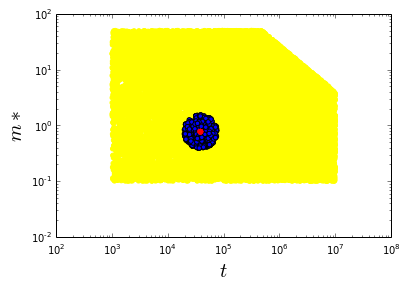

In [12]:
# This chuck is to test the extent of the proposal function

edades = []
masas =[]
inclis = [] 
for i in arange(1000):
    id_test = g(3013101,5,1,1,1)[0]
    incl_test = g(3013101,5,1,1,1)[1]
    edades.append(idl_dict['age'][where(idl_dict['id'] == id_test)][incl_test])
    masas.append(idl_dict['massc'][where(idl_dict['id'] == id_test)][incl_test])
    inclis.append(incl_test)
    
plt.scatter(age1,mass1,color='yellow')
plt.scatter(edades,masas)
plt.scatter(idl_dict['age'][where(idl_dict['id'] == 3013101)],idl_dict['massc'][where(idl_dict['id'] == 3013101)],color='red')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$t$',size=20)
plt.ylabel('$m*$',size=20)

#plt.xlim([1E4,2E5])
#plt.ylim([2E-1,2E0])

#plt.hist(inclis)

Generating mock data of two sources
---------------------------------------

In order to test the algorithm here I generate mock photometry for two sources that will appear resolved in the short-wavelength (optical, near-IR and mid-IR) bands and blended together in the far-IR bands. To create these SEDs I use existing SEDs from the Robitaille grid and add 10% Gaussian noise. Briefly, I first read the models (convolved with the band filters) and the respective paramteres, apply a given extinction to each source, and put them at a certain distance. I then plot the resulting SEDs.

The extinction law used is described in [this paper](http://adsabs.harvard.edu/abs/2007ApJS..169..328R). The function defined in the next box takes the central wavelenghts of the filters and the desired $A_V$ and returns the multiplicative factors to be applied to the photometry for each of the corresponding bands. 

In [13]:
# Define extinction law

ext_law = ascii.read("/data/irac12/jmartine/clustered/model_jr/fitter/extinction_law.ascii")    # This is the extinction law (Fischera et al. 2005)
wavita = ext_law['col1']
opacita = ext_law['col2']

filter_waves = np.array([0.36,0.44,0.55,1.235,2.159,3.550,4.493,5.731,7.872,23.68,71.889,102.457,166.186,252.051,362.088])


def ext_law(wavelengths_filters, Av):
    A_lambda = Av * (opacita/211.4)
    A_lambda_waves = np.interp(wavelengths_filters,wavita,A_lambda)
    corr_factor = 10.0**(-0.4*A_lambda_waves)   # This is the array of correction factors to be applied to each band
    return corr_factor

The two sources are chosen in the next box using their ID number. The corresponding masses and ages can be found using the box above. The inclinations and extinctions assigned are hard coded, and for this particular case, they correspond to inclination number 5 and an $A_V=2.5$ Errors assigned are 10%. Plotted are the two resulting SEDs, resolved in all bands, as well as the integrated fluxes in all bands. The observing bands that we will consider here are $U$, $B$, $V$, $J$, $H$, $K_s$, $\rm{IRAC}_{3.6}$, $\rm{IRAC}_{4.5}$, $\rm{IRAC}_{5.8}$, $\rm{IRAC}_{8.0}$, $\rm{MIPS}_{24}$, $\rm{PACS}_{70}$, $\rm{PACS}_{100}$, $\rm{PACS}_{160}$, $\rm{SPIRE}_{250}$, and $\rm{SPIRE}_{350}$. We will assume that sources are resolved in all short-wavelength bands up to 8 microns, and unresolved (blended) together in the remaining bands. For the latter, only the integrated flux of the two sources is available from the observations.

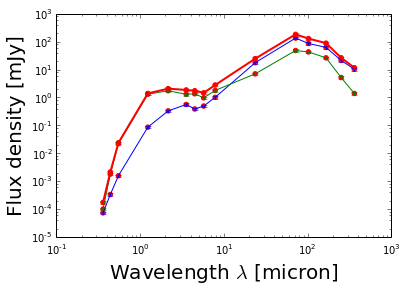

In [14]:
# This chunk generates fake data

disto = 5.1  # distance to the source [kpc]   # Distance to the sources

# Filters and wavelenghts are hard coded, but in principle should just be read from a table
filter_names = ['model_str_bu','model_str_bb','model_str_bv','model_str_2j','model_str_2k','model_str_i1',
                'model_str_i2','model_str_i3','model_str_i4','model_str_m1','model_str_pacs1','model_str_pacs2',
                'model_str_pacs3','model_str_spir1','model_str_spir2']
filter_wavelengths = np.array([0.36,0.44,0.55,1.235,2.159,3.550,4.493,5.731,7.872,23.68,71.889,102.457,166.186,252.051,362.088])
source_A_fluxes = []
source_B_fluxes = []


# Loop over bands to assign them fluxes (source A)
for filter in filter_names:
    nombres = idl_dict1[filter]['name'][0]
    angulos = idl_dict1[filter]['angle'][0]
    at = where((nombres == 3018785) & (angulos == idl_dict1['model_str_bu']['angle'][0][5])) 
    #at = where((nombres == 3019785) & (angulos == idl_dict1['model_str_bu']['angle'][0][5])) 
    source_A_fluxes.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

source_A_fluxes = np.array(source_A_fluxes)

obs_fluxes_A = 10.**(log10(source_A_fluxes) + np.random.normal(0., 0.1, filter_wavelengths.shape))
obs_fluxes_A *= ext_law(filter_wavelengths,2.5)/(disto**2)   # Apply extinction and distance scaling


# Loop over bands to assign them fluxes (source B)
for filter in filter_names:
    nombres = idl_dict1[filter]['name'][0]
    angulos = idl_dict1[filter]['angle'][0]
    at = where((nombres == 3018685) & (angulos == idl_dict1['model_str_bu']['angle'][0][5])) 
    #at = where((nombres == 3018285) & (angulos == idl_dict1['model_str_bu']['angle'][0][5]))
    source_B_fluxes.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

source_B_fluxes = np.array(source_B_fluxes)

# Add errors and extinction law, as well as distance scaling
obs_fluxes_B = 10.**(log10(source_B_fluxes) + np.random.normal(0., 0.1, filter_wavelengths.shape))
obs_fluxes_B *= ext_law(filter_wavelengths,2.5)/(disto**2)   # Apply extinction and distance scaling


# Unresolved fluxes.
obs_fluxes_total = obs_fluxes_A + obs_fluxes_B


#plt.scatter(filter_wavelengths,source_fluxes)
plt.scatter(filter_wavelengths,obs_fluxes_A,color='red')
plt.errorbar(filter_wavelengths,obs_fluxes_A, yerr=0.1*obs_fluxes_A)
plt.scatter(filter_wavelengths,obs_fluxes_B,color='red')
plt.errorbar(filter_wavelengths,obs_fluxes_B, yerr=0.1*obs_fluxes_B)
plt.scatter(filter_wavelengths,obs_fluxes_total,color='red')
plt.errorbar(filter_wavelengths,obs_fluxes_total, yerr=0.1*obs_fluxes_total,linewidth=2)
#plt.plot(filter_wavelengths,obs_fluxes_A/(1.1**2.0))
#plt.plot(filter_wavelengths,obs_fluxes_A/(0.9**2.0))
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Wavelength $\lambda$ [micron]',size=20)
plt.ylabel('Flux density [mJy]',size=20)

The EM algorithm
------------------
We now implement the EM algorithm proper. Although presented here for the case of two sources, it can be easily generalized to include more sources. 

**STEP 0: Assuming initial set of parameters**

We start by assuming initial parameters for the sources involved. We have 4 free parameteres in the model for each source: $m_*$, $t$, $A_V$, and $\phi$, and so in general for $n$ sources we will have $4n$ parameters to set. A good first guess for the parameters can be obtained by fiting the resolved photometry individually for each source (bands $U$ to $\rm{IRAC}_8$) and then use the parameters that maximize the likelihood in each case as initial parameters. This is what we have done here. We obtain:

*Source A:*  
Model: 3011046  
$\log m_* = -0.310425$  
$\log t = 4.67912$  
$\phi = 6$  
$A_V = 1.1183927$

*Source B:*  
Model: 3005492  
$\log m_* = 0.029262$  
$\log t = 5.17826$  
$\phi = 4$  
$A_V = 2.20656794$

These initial guesses give a good fit to the resolved bands, but not necessarily to the unresolved data, where our assumed model might perform very poorly. In the plot below we show the data and the models corresponding to our initial guess. The integrated model (line red) fits the short-wavelength integrated fluxes, but not so well the far-IR data. Furthermore, we note that the contributions of each of the two YSO models to the total flux is wrong with respect to the actual real models, that for this example we know in advance. Of course, this is not surprising.  The goal then is to use the EM algorithm to converge to a solution (i.e., a set of model parameters for both sources) that not only recover corectly the integrated fluxes in the long wavelengths, but that also approximates the relative contributions from each source, or at least produces probabilities for these contributions.

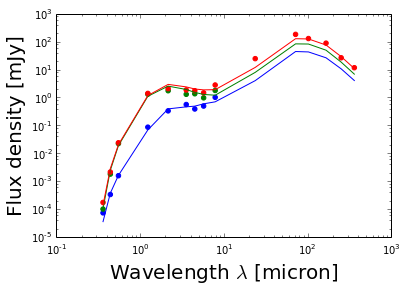

In [15]:
source_C_fluxes = []
source_D_fluxes = []

# Loop over bands to assign them fluxes (source A)
for filter in filter_names:
    nombres = idl_dict1[filter]['name'][0]
    angulos = idl_dict1[filter]['angle'][0]
    at = where((nombres == 3011046) & (angulos == idl_dict1['model_str_bu']['angle'][0][6])) 
    source_C_fluxes.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

source_C_fluxes = np.array(source_C_fluxes)

obs_fluxes_C = 10.**(log10(source_C_fluxes))
obs_fluxes_C *= ext_law(filter_wavelengths,1.1183927)/(disto**2)   # Apply extinction and distance scaling


# Loop over bands to assign them fluxes (source B)
for filter in filter_names:
    nombres = idl_dict1[filter]['name'][0]
    angulos = idl_dict1[filter]['angle'][0]
    at = where((nombres == 3005492) & (angulos == idl_dict1['model_str_bu']['angle'][0][4])) 
    source_D_fluxes.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

source_D_fluxes = np.array(source_D_fluxes)

# Add errors and extinction law, as well as distance scaling
obs_fluxes_D = 10.**(log10(source_D_fluxes))
obs_fluxes_D *= ext_law(filter_wavelengths,2.20656794)/(disto**2)   # Apply extinction and distance scaling


# Integrated flux from model.
obs_fluxes_int = obs_fluxes_C + obs_fluxes_D

plt.plot(filter_wavelengths,obs_fluxes_C)
plt.scatter(filter_wavelengths[:9],obs_fluxes_A[:9],color='blue')
plt.plot(filter_wavelengths,obs_fluxes_D)
plt.scatter(filter_wavelengths[:9],obs_fluxes_B[:9],color='green')
plt.scatter(filter_wavelengths,obs_fluxes_total,color='red')
plt.plot(filter_wavelengths,obs_fluxes_int, color='red')

plt.xscale('log')
plt.yscale('log')

plt.xlim(1E-1,1E3)
plt.ylim(1E-5,1E3)

plt.xlabel('Wavelength $\lambda$ [micron]',size=20)
plt.ylabel('Flux density [mJy]',size=20)

**ITERATION 1, STEP 1: E-step**

Let us begin by taking the first available observation (the MIPS 24 micron point) and, assuming our initial model parameters to be true, calculate the likelihood of those parameters generating the observed photometry at 24 microns. In order to do so, we need to realize that the sum of two models at 24 microns should give us the observed value, but we do not know how much is each source is contributing. Our data is incomplete. We therefore calculate likelihoods for all possible completions of the data (i.e. all posible combinations of $F_{24}^A$ and $F_{24}^B$ such that the sum of both gives the observed value).

For each of the two sources $i$ and each possible completion of the data $j$, we calculate one likelihood $\mathcal{L}_i(D|M_j)$, using all the resolved datapoints plus the proposed completion datapoint. For each completion, the joint likelihood for all sources $n=2$ would then be:

$$\mathcal{L}_{\rm{joint}}(D|M_j) = \prod_{i=0}^{n}\mathcal{L}_i(D|M_j)$$

Where we have been careful to normalize the individual likelihoods first (i.e., at least one of the proposed completions should be the solution, and the sum of probabilities over completions should equal unity). The resulting joint likelihood gives the probability of a particular combination of the fluxes $A$ and $B$ producing the observed 24 micron photometry, given the assumed model parameters. 

We can then repeat this calculation for each of the remaining unresolved datapoints and fro each of them we can obtain a rpobability distribution. In the plot below we show the resulting probability distribution for each of the six unresolved datapoints ($\rm{MIPS}_{24}$, $\rm{PACS}_{70}$, $\rm{PACS}_{100}$, $\rm{PACS}_{160}$, $\rm{SPIRE}_{250}$, and $\rm{SPIRE}_{350}$).

The resulting probability distributions can be maximized to obtain new guesses for the unresolved photometry (i.e., for the contribution of each of the sources to the unresolved photometry). To obtain updated model parameters, we maximize the likelihood of the newly obained data given the models. In other words, we fit the full guessed photometry for each of the two sources and pick the model parameters that maximize the likelihood. These are our updated model parameters after the first iteration.

[  24.61095325  182.41776132  129.24080022   88.3239733    26.3919582
   11.64118836]


/home/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in log10
/home/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in log10


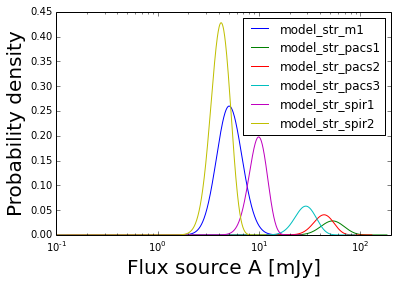

In [229]:
# ITERATION 1, STEP 1: E-step:

# Initial guess for the parameters
new_params_A = [3011046,6,1.1183927]
new_params_B = [3005492,4,2.20656794]

print obs_fluxes_total[9:]

disto = 5.1  # distance to the source [kpc]

filter_names = ['model_str_bu','model_str_bb','model_str_bv','model_str_2j','model_str_2k','model_str_i1',
                'model_str_i2','model_str_i3','model_str_i4','model_str_m1','model_str_pacs1','model_str_pacs2',
                'model_str_pacs3','model_str_spir1','model_str_spir2']
filter_wavelengths = np.array([0.36,0.44,0.55,1.235,2.159,3.550,4.493,5.731,7.872,23.68,71.889,102.457,166.186,252.051,362.088])

# The following function calculates the joint log likelihood for the sources, maximizes them
# for each unresolved filter, and return updated photometry
def joint_likelihood (filter_names, filter_wavelengths, index,new_params_A, new_params_B): # index refers to the first unresolved filter
        
    new_fluxes_A = []
    new_fluxes_B = []

    # The loop goes over the unreolved datapoints (i.e., from MIPS24 to PACS350)
    for i in arange(index,len(filter_names)):
    
        # List of resolved filters plus current unresolved filters.
        list_filters = np.append(filter_names[0:index],filter_names[i])


        source_A_model = []
        source_B_model = []
    
        # Corresponding wavelengths
        waves = np.append(filter_wavelengths[0:index],filter_wavelengths[i])

        # Match parameters with model array
        for filter in list_filters:
            nombres = idl_dict1[filter]['name'][0]
            angulos = idl_dict1[filter]['angle'][0]
            at = where((nombres == new_params_A[0]) & (angulos == idl_dict1['model_str_bu']['angle'][0][new_params_A[1]])) 
            source_A_model.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

        source_A_model = np.array(source_A_model)
        source_A_model *= ext_law(waves,new_params_A[2])/(disto**2)   # Apply extinction and distance scaling to first source

        # We do the same for the second source
        for filter in list_filters:
            nombres = idl_dict1[filter]['name'][0]
            angulos = idl_dict1[filter]['angle'][0]
            at = where((nombres == new_params_B[0]) & (angulos == idl_dict1['model_str_bu']['angle'][0][new_params_B[1]])) 
            source_B_model.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

        source_B_model = np.array(source_B_model)
        source_B_model *= ext_law(waves,new_params_B[2])/(disto**2)   # Apply extinction and distance scaling
    
        # Combined emission from both sources in the resolved filters plus current unresolved filter.
        model_total = source_A_model + source_B_model
        
        # Create a logarithmic grid of contributions of source A to the total flux in the current band (possible completions)
        cont_A = linspace(log10(0.001*obs_fluxes_total[i]),log10(obs_fluxes_total[i]),1000)
        likes_A = []
        likes_B = []

        # Loop over completions to calculate likelihoods
        for element in cont_A:
            log_obs_fluxes_A_arr = np.array(log10(obs_fluxes_A[0:index]))
            log_obs_fluxes_A_arr = np.append(log_obs_fluxes_A_arr,element)
            log_obs_fluxes_B_arr = np.array(log10(obs_fluxes_B[0:index]))
            log_obs_fluxes_B_arr = np.append(log_obs_fluxes_B_arr,log10(obs_fluxes_total[i]-10.0**element))
            likes_A.append(likelihood(10.0**log_obs_fluxes_A_arr,0.08*10.**(log_obs_fluxes_A_arr),source_A_model,1.0)['likelihood'])
            likes_B.append(likelihood(10.0**log_obs_fluxes_B_arr,0.08*10.**(log_obs_fluxes_B_arr),source_B_model,1.0)['likelihood'])
    
    
        # Normalization of probabilities for each source
        normA = np.trapz(likes_A,10.0**cont_A)
        cont_B = obs_fluxes_total[i]-10.0**cont_A
        likes_B[-1] = 0.0
        normB = np.trapz(likes_B[::-1],cont_B[::-1])

        likes_norm_A = likes_A/normA
        likes_norm_B = likes_B/normB
    
        log_like_A = log10(likes_norm_A)  # Log likelihoods
        log_like_B = log10(likes_norm_B)
        
        prob_final = []
       
        # Here we sum the log likelihoods to obtain the joint probability for the current band
        for flux_A in 10.0**cont_A:
            prob_final.append(mean(log_like_A[where(10.0**cont_A == flux_A)]+log_like_B[where(10.0**cont_A == flux_A)]))
        
        prob_final = np.array(prob_final)
    
        # Fix last element, which is inf
        prob_final[-1] = -60.0
    
        # Normalization of the joint probability
    
        norm_final = np.trapz(10.0**prob_final,10.0**cont_A)
        prob_final_norm = 10.0**prob_final/norm_final
    
    
        # Plot the joint likelihood
    
        plt.plot(10.0**cont_A,prob_final_norm,label=filter_names[i])
        
        #print mean(10.0**cont_A[where(prob_final_norm == max(prob_final_norm))]),obs_fluxes_total[i]-mean(10.0**cont_A[where(prob_final_norm == max(prob_final_norm))])
    
    
        # For each joint likelihood, get the fluxes that maximize it. These are the fluxes that will provide new model parameters
        new_fluxes_A.append(mean(10.0**cont_A[where(prob_final_norm == max(prob_final_norm))]))
        new_fluxes_B.append(obs_fluxes_total[i]-mean(10.0**cont_A[where(prob_final_norm == max(prob_final_norm))]))
        
        plt.legend(loc=1)

        plt.xlabel('Flux source A [mJy]',size=20)
        plt.ylabel('Probability density',size=20)
        plt.xscale('log')
        #plt.yscale('log')
        plt.xlim(0.1,200)
        
        
    return [new_fluxes_A,new_fluxes_B]
    
new_fluxes_A,new_fluxes_B = joint_likelihood(filter_names,filter_wavelengths,9,new_params_A, new_params_B)  


**ITERATION 1, STEP 2: M-step**

In order to get new parameters, we now use our MCMC fitter to fit the new photometry for each of the sources individually. The model parameters that maximize the likelihood of the new data are the new parameters, that will be used in the following iteration. For the MCMC fitting we use the Metropolis algorithm with the proposal function shown above. The output is a set of samples whose distribution should resemble the target posterior probability distribution for the model parameters, given the data. 

Below, we first set the parameters for the Metropolis algorithm. We then perform a MCMC with 10000 iterations to sample the posterior PDF (we do this for one of the sources for illustrative purposes), and produce histograms for the model parameters. We then choose as the new parameters those that maximize the posterior PDF and plot the best-fit to the photometry together with all models that have a $\chi^2$ of 3 times the minimum value or less.

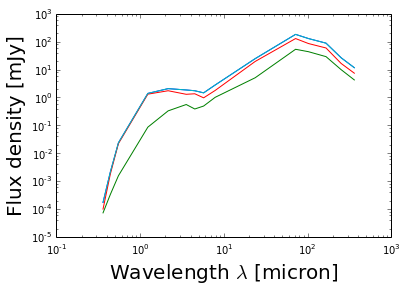

In [17]:
# Here we choose one of the sources to perform the fitting, and plot the photometry for the current iteration

# Photometry for each source
new_data_A = np.append(obs_fluxes_A[0:9],new_fluxes_A)
new_data_B = np.append(obs_fluxes_B[0:9],new_fluxes_B)

# Fluxes and errors
obs_fluxes = new_data_A
obs_errors = 0.08*obs_fluxes

# Plot fluxes
plt.plot(filter_wavelengths,new_data_A+new_data_B)
plt.plot(filter_wavelengths,new_data_A)
plt.plot(filter_wavelengths,new_data_B)
plt.plot(filter_wavelengths,obs_fluxes_total)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Wavelength $\lambda$ [micron]',size=20)
plt.ylabel('Flux density [mJy]',size=20)

In [18]:
# NOW THE METROPOLIS ALGORITHM

# Setup of th initial values and algorithm parameters

init = [3018785,8,2.0,5.1,5.1]     # Starting point                         
N = 10000                       # Number of samples

In [121]:
# Main MCMC function. Here we define a function to perform the Metropolis algorithm. The function returns
# the trace, the set of likelihoods and chi^2 values, as well as the new parameters.

def mh (Ns, x0, filter_names,obs_fluxes,obs_errors):
        
    xsample=np.zeros((5,Ns))
    likelihoods = np.zeros(Ns)
    chi2s = np.zeros(Ns)
    xsample[:,0]=x0
    acceptcnt=0
    cnt=0 # Initialize counts

    list_filters = filter_names
    model_fluxes_prop = []

    # Assign fluxes to the model SEDs
    for filter in list_filters:
        nombres = idl_dict1[filter]['name'][0]
        angulos = idl_dict1[filter]['angle'][0]
        at = where((nombres == xsample[0,0]) & (angulos == idl_dict1['model_str_bu']['angle'][0][xsample[1,0].astype(int)])) 
        model_fluxes_prop.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

    corr_ext = ext_law(filter_wavelengths,xsample[2,0])   # Extinction correction

    # Initial likelihood (i.e. likelihood function evaluated at the initial guess values)
    lprop_old = np.log10(likelihood(obs_fluxes,obs_errors,corr_ext*model_fluxes_prop/(xsample[3,0]**2),1.0)['likelihood']) # LOGLIKELIHOOD HERE!! COMPUTE THE LOG

    # Initial chi squared value
    chi2_old = likelihood(obs_fluxes,obs_errors,corr_ext*model_fluxes_prop/(xsample[3,0]**2),1.0)['chi2']

    # We start filling the arrays for likelihood and chi square distributions
    likelihoods[0] = lprop_old
    chi2s[0] = chi2_old
    
    # Main loop
    while cnt+1 < Ns:
        #if (cnt%100 == 0): print cnt
    
        xstar = g(xsample[0,cnt].astype(int),xsample[1,cnt].astype(int),xsample[2,cnt],xsample[3,cnt],xsample[4,cnt]) # The next step in the chain is sampled randomly from a Gaussian
        ages_star = idl_dict['age'][where(idl_dict['id']==xstar[0].astype(int))][xstar[1].astype(int)]  # Corresponding age for proposed step
        masses_star = idl_dict['massc'][where(idl_dict['id']==xstar[0].astype(int))][xstar[1].astype(int)]  # Corresponding mass for proposed step
        corr_ext = ext_law(filter_wavelengths,xstar[2])
        plt.scatter(ages_star,masses_star)
        model_fluxes_star = []
    
        # Assign fluxes for proposed step
        for filter in list_filters:
            nombres = idl_dict1[filter]['name'][0]
            angulos = idl_dict1[filter]['angle'][0]
            at = where((nombres == xstar[0].astype(int)) & (angulos == idl_dict1['model_str_bu']['angle'][0][xstar[1].astype(int)])) 
            model_fluxes_star.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))
    
        # The following at the new likelihood anc chi squared value
        if (likelihood(obs_fluxes,obs_errors,corr_ext*model_fluxes_star/(xstar[3]**2),1.0)['likelihood'] < 1E-200):
            lprop_new = -200.00
        else:
            lprop_new = np.log10(likelihood(obs_fluxes,obs_errors,corr_ext*model_fluxes_star/(xstar[3]**2),1.0)['likelihood'])
        chi2_new = likelihood(obs_fluxes,obs_errors,corr_ext*model_fluxes_star/(xstar[3]**2),1.0)['chi2']
    
        # Acceptance
        if (lprop_new - lprop_old) > np.log(np.random.uniform(0,1,1)):  # Acceptance ratio. Notice that here only the ratio of the evaluated functions matters.
            x0=xstar
            ages_out = idl_dict['age'][where(idl_dict['id']==xstar[0].astype(int))][xstar[1].astype(int)]
            masses_out = idl_dict['massc'][where(idl_dict['id']==xstar[0].astype(int))][xstar[1].astype(int)]
            plt.scatter(ages_out,masses_out,color='red')
            lprop_old=lprop_new
            chi2_old=chi2_new
            acceptcnt += 1
        
        cnt += 1
        xsample[:,cnt]=x0
        likelihoods[cnt]=lprop_old
        chi2s[cnt]=chi2_old

    # The actual parameters (from the model used tio generate the mock photometry). Used for comparison.
    ages_real = idl_dict['age'][where(idl_dict['id']==3018785)][8]
    masses_real = idl_dict['massc'][where(idl_dict['id']==3018785)][8]

    # Plot steps of the chain
    plt.scatter(ages_real,masses_real,color='yellow',s=40)    
    
    plt.xscale('log')
    #plt.yscale('log')

    plt.xlabel('Age [yr]',size=20)
    plt.ylabel('Mass [M$_{\odot}$]',size=20)

    # Save the chain
    with open('output_chain.pickle', 'w') as f:
        pickle.dump([xsample,likelihoods,chi2s], f)
        
    # Burn-in 20%
    xout=xsample[:,Ns/5:] 
    likeli_out=likelihoods[Ns/5:]
    chi2out=chi2s[Ns/5:]
    
    # Get best fit (the one that minimizes chi^2)
    alo = where(chi2out == min(chi2out))
    ola = where(likeli_out == max(likeli_out))
    
    new_params = [xout[0][ola][0].astype(int),xout[1][ola][0].astype(int),xout[2][ola][0]]
        
    return [xout,likeli_out,chi2out,new_params]

--- 236.519021988 seconds ---


/home/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10


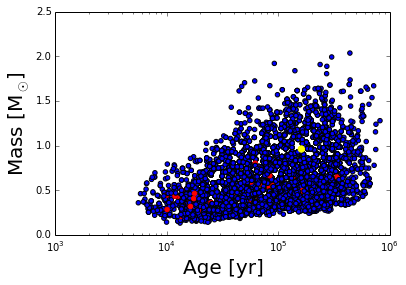

In [20]:
import time
start_time = time.time()

# Run the MCMC
xout,likeli_out,chi2out,new_params_A = mh(N,init,filter_names,obs_fluxes,obs_errors)

# Print computing time
print("--- %s seconds ---" % (time.time() - start_time))

To ilustrate the result of the MCMC, below we plot the 2D histogram in the mass-age space of the chain obtained. The shown distribution is an approximation of the uinderlying target distribution of probabilities, and hence represents the solution to the fitting problem. We then plot the data for source A, and the corresponding best fit. The gray area corresponds to all models that fit the data with $\chi^2 < \chi^2_{\rm{min}}$

(0,)


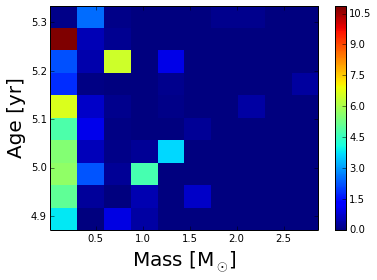

In [21]:
# PLOT HISTOGRAMS

ages_out = []   # Array for ages
masses_out = [] # Array for masses

print shape(idl_dict['age'][where(idl_dict['id']==id)])

# We asign parameters for the elements of the chain
for id in xout[0]:
    ages_out.append(idl_dict['age'][where(idl_dict['id']==id)][0])
    masses_out.append(idl_dict['massc'][where(idl_dict['id']==id)][0])

# And plot the results
#plt.hist2d(np.log10(ages_out), np.log10(masses_out), normed=True, bins=8)
plt.hist2d(xout[2], xout[3], normed=True)
colorbar()

plt.ylabel('Age [yr]',size=20)
plt.xlabel('Mass [M$_{\odot}$]',size=20)
#plt.contour(np.log10(ages_out), np.log10(masses_out))
#plt.hist(np.log10(ages_out),bins=8)
#plt.hist(xout[3],bins=8)

#plt.savefig('hist_1ordermag.ps')

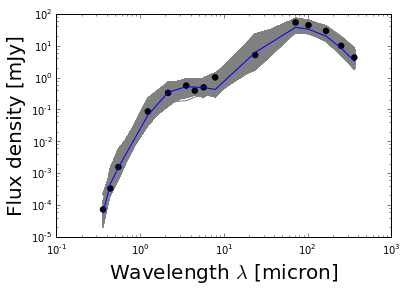

In [23]:
# PLOTS SEDS

indices = where(chi2out < 3.0*min(chi2out))
ind_min = where(chi2out == min(chi2out))
for index in indices[0]:
    model_fluxes_out = []
    for filter in filter_names:
        nombres = idl_dict1[filter]['name'][0]
        angulos = idl_dict1[filter]['angle'][0]
        at = where((nombres == xout[0][index]) & (angulos == idl_dict1['model_str_bu']['angle'][0][xout[1][index].astype(int)]))        
        model_fluxes_out.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))
    
    # Extinction correction
    corri = ext_law(filter_wavelengths,xout[2][index])
    model_fluxes_out = corri*model_fluxes_out*(1.0/(xout[3][index]**2))
    
    # Choose best fit
    if (index == ind_min[0][0]):
        wave_best = filter_wavelengths
        flux_best = model_fluxes_out
    else:
        plt.plot(filter_wavelengths,model_fluxes_out,color='gray',zorder=1)

# Plot results 
plt.scatter(filter_wavelengths,obs_fluxes,color='black',marker='o',s=30,zorder=2)
plt.plot(wave_best,flux_best,color='blue',zorder=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength $\lambda$ [micron]',size=20)
plt.ylabel('Flux density [mJy]',size=20)


**EM single iteration**

Let us now write a procedure to perform a single EM iteration. Note that each iteration would repeat the process we have just described for every single source in the ensemble (currently only two sources are implemented) and generate a set of new parameters for each of them. The procedure takes the current best guesses for the parameters as input, and returns a new set of parameters, to be used as input for the following iteration. 

So we do not get lost, let us briefly recapitulate: we start with guesses for the model parameters derived from the resolved photometry of the observed sources, we then impose the condition that for each of the unresolved bands, the sum of the fluxes from all sources must equal the observed spatially unresolved photometry, and derive joint probabilities for all possible combination of fluxes. At each EM iteration, we maximize those probabilities and use the resulting photometry to obtain updated model parameters via the MCMC fitter. This must be iterated until certain convergence criterium has been met. The individual SEDs of the sources should converge to the most likely solution given the resolved and unresolved data.

So the next part is just a wrap up to account for all sources in a single EM iteration. In a later, final step, we will write  aprocedure for the EM algorith, that will include many iterations.

In [223]:
# EM single iteration

# Set distance and filters to be used
disto = 5.1  # distance to the source [kpc]

filter_names = ['model_str_bu','model_str_bb','model_str_bv','model_str_2j','model_str_2k','model_str_i1',
                'model_str_i2','model_str_i3','model_str_i4','model_str_m1','model_str_pacs1','model_str_pacs2',
                'model_str_pacs3','model_str_spir1','model_str_spir2']
filter_wavelengths = np.array([0.36,0.44,0.55,1.235,2.159,3.550,4.493,5.731,7.872,23.68,71.889,102.457,166.186,252.051,362.088])


# This EM iteration takes inital parameters, distance to the source and initial 
# guessed params for the source, and returns new set of parameters
def em_single(new_params_A, new_params_B, disto):
            
    new_fluxes_A,new_fluxes_B = joint_likelihood(filter_names,filter_wavelengths,9,new_params_A, new_params_B) 
            
    # Now we maximize likelihood by running the fitter on the resulting data        

    # Arrays with current photometry
    new_data_A = np.append(obs_fluxes_A[0:9],new_fluxes_A)
    new_data_B = np.append(obs_fluxes_B[0:9],new_fluxes_B)
        
    new_data = [[new_data_A],[new_data_B]]
    new_params = []
    
    plt.plot(filter_wavelengths,new_data_B)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Wavelength $\lambda$ [micron]',size=20)
    plt.ylabel('Flux density [mJy]',size=20)
    plt.xlim(1E1,5E2)
    plt.ylim(1E-1,1E3)
    
    # Loop over the sources
    for i in arange(len(new_data)):
        obs_fluxes = new_data[i]
        obs_fluxes = np.array(obs_fluxes)
        obs_errors = 0.08*obs_fluxes
        
        # Setup of the initial values and algorithm parameters
        #init = [initial[i][0], initial[i][1], initial[i][2], disto, disto]          # Starting point
        init = [3018785,8,2.0,5.1,5.1]
        N = 3000                       # Number of samples
        
        # Run the MCMC
        xout,likeli_out,chi2out,new_par = mh(N,init,filter_names,obs_fluxes,obs_errors)
        
        # Get new parameters for current source
        new_params.append(new_par)
        
    return new_params

**EM Procedure**

This procedure calls the single EM iteration until convergence is reached. In our case, rather than a convergence criterium, we just limit the number of iterations. After defininf the EM procedure, there is a piece of code to try to guess a sensible mass of each source based on their K-band photometry. Alternatively, the initial guess can be obtained from fitting the resolved photometry for each source.

In [224]:
def em(params_A,params_B, iterations=5):
    iteration = 0
    while iteration<iterations:
        new_prior = em_single(params_A,params_B,disto)
        params_A = new_prior[0]
        params_B = new_prior[1]
        iteration+=1
        print new_prior,iteration
    return [new_prior, iteration]

In [225]:
# Obtain K-band fluxes for the sources
log_F_k = log10([mean(obs_fluxes_A[where(np.array(filter_names) == 'model_str_2k')]),
       mean(obs_fluxes_B[where(np.array(filter_names) == 'model_str_2k')])])

# Estimate a mass for the sources based on a M-luminoisty correlation based on model data
M_guess = 0.2*(1./3)*(log_F_k-0.6+2*log10(disto))

# Assing masses to models
id_guess_A = max(id1[where(abs(M_guess[0]-log10(mass1)) < 0.02)]).astype(int)
id_guess_B = max(id1[where(abs(M_guess[1]-log10(mass1)) < 0.02)]).astype(int)

# Set the initial parameters for the EM algorithm
params_A = [id_guess_A, 5, 2.0]
params_B = [id_guess_B, 5, 2,0]

#params_A = final_params[0][0]
#params_B = final_params[0][1]

#params_A = [3019785, 4, 2.0778854122059096]
#params_B = [3000258, 6, 1.619917276540678]

# Alternatively, just enter your prefered initial values (from SED fitting, for example)
params_A = [3006090,5,1.59428362110252]
params_B = [3017068,7,2.1713011475193023]

#print params_A
#print params_B

print id_guess_A



#final_params =  em(params_A,params_B)

3020113


**Running the EM algorithm for our mock data**

We now run the procedure with a maximum of 5 iterations for the mock data we have generated. After the final parameters have been obtained from this run, we plot the results of the converged SEDs for each source and compare them with the original mock photoemtry. Note how the algorithm is able to "guess" the actual shape of the individual SEDs. In other words, starting from the resolved photometry in the short-wavelength bands and the unresolved photometry in the long-wavelength bands, we are able to make a pretty decent guess on how the unresolved fluxes break up among sources.

/home/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in log10
/home/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in log10
/home/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10


[[3008942, 4, 2.0524225802801328], [3008617, 7, 4.7839918072208496]] 1
[[3009170, 7, 1.3722347420371603], [3017068, 6, 1.695470723916811]] 2
[[3009170, 7, 1.5909343040137425], [3002689, 5, 3.193538776615231]] 3
[[3011275, 4, 0.29160384331096795], [3017068, 7, 1.9139510806581443]] 4
[[3006741, 8, 1.3729438920574368], [3008617, 5, 3.4924563102181585]] 5


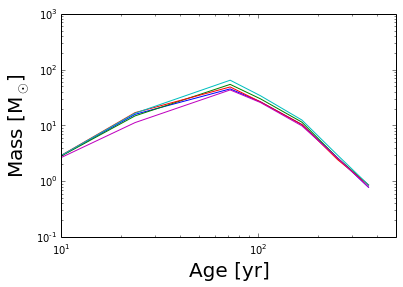

In [226]:
final_params =  em(params_A, params_B)

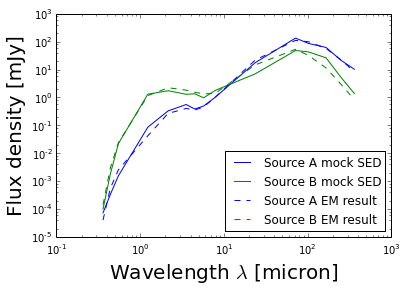

In [228]:
# Plot derived SEDs and original mock photometry

source_C_fluxes = []
source_D_fluxes = []

for filter in filter_names:
    nombres = idl_dict1[filter]['name'][0]
    angulos = idl_dict1[filter]['angle'][0]
    at = where((nombres == final_params[0][0][0].astype(int)) & (angulos == idl_dict1['model_str_bu']['angle'][0][final_params[0][0][1].astype(int)])) 
    source_C_fluxes.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

source_C_fluxes = np.array(source_C_fluxes)

obs_fluxes_C = 10.**(log10(source_C_fluxes)) 
obs_fluxes_C *= ext_law(filter_wavelengths,final_params[0][0][2])/(disto**2)   # Apply extinction and distance scaling


for filter in filter_names:
    nombres = idl_dict1[filter]['name'][0]
    angulos = idl_dict1[filter]['angle'][0]
    at = where((nombres == final_params[0][1][0].astype(int)) & (angulos == idl_dict1['model_str_bu']['angle'][0][final_params[0][1][1].astype(int)])) 
    source_D_fluxes.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

source_D_fluxes = np.array(source_D_fluxes)

obs_fluxes_D = 10.**(log10(source_D_fluxes)) 
obs_fluxes_D *= ext_law(filter_wavelengths,final_params[0][1][2])/(disto**2)   # Apply extinction and distance scaling

obs_fluxes_total = obs_fluxes_A + obs_fluxes_B
obs_fluxes_total_after = obs_fluxes_C + obs_fluxes_D




# Initial guess SEDs

source_A_fluxes_ini = []
source_B_fluxes_ini = []


# Loop over bands to assign them fluxes (source A)
for filter in filter_names:
    nombres = idl_dict1[filter]['name'][0]
    angulos = idl_dict1[filter]['angle'][0]
    at = where((nombres == id_guess_A) & (angulos == idl_dict1['model_str_bu']['angle'][0][5])) 
    #at = where((nombres == 3019785) & (angulos == idl_dict1['model_str_bu']['angle'][0][5])) 
    source_A_fluxes_ini.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

source_A_fluxes_ini = np.array(source_A_fluxes_ini)

obs_fluxes_A_ini = 10.**(log10(source_A_fluxes_ini) + np.random.normal(0., 0.08, filter_wavelengths.shape))
obs_fluxes_A_ini *= ext_law(filter_wavelengths,2.0)/(disto**2)   # Apply extinction and distance scaling


# Loop over bands to assign them fluxes (source B)
for filter in filter_names:
    nombres = idl_dict1[filter]['name'][0]
    angulos = idl_dict1[filter]['angle'][0]
    at = where((nombres == id_guess_B) & (angulos == idl_dict1['model_str_bu']['angle'][0][5])) 
    #at = where((nombres == 3018285) & (angulos == idl_dict1['model_str_bu']['angle'][0][5]))
    source_B_fluxes_ini.append(mean(idl_dict1[filter]['fluxes'][0][49][at]))

source_B_fluxes_ini = np.array(source_B_fluxes)

# Add errors and extinction law, as well as distance scaling
obs_fluxes_B_ini = 10.**(log10(source_B_fluxes_ini) + np.random.normal(0., 0.08, filter_wavelengths.shape))
obs_fluxes_B_ini *= ext_law(filter_wavelengths,2.0)/(disto**2)   # Apply extinction and distance scaling




plt.plot(filter_wavelengths,obs_fluxes_A,color='blue',label='Source A mock SED')
#plt.errorbar(filter_wavelengths,obs_fluxes_A, yerr=0.1*obs_fluxes_A)
plt.plot(filter_wavelengths,obs_fluxes_B,color='green',label='Source B mock SED')
#plt.errorbar(filter_wavelengths,obs_fluxes_B, yerr=0.1*obs_fluxes_B)
#plt.scatter(filter_wavelengths,obs_fluxes_total,color='red')
#plt.errorbar(filter_wavelengths,obs_fluxes_total, yerr=0.1*obs_fluxes_total,linewidth=2)
plt.plot(filter_wavelengths,obs_fluxes_C,color='blue',label='Source A EM result',linestyle='--')
plt.plot(filter_wavelengths,obs_fluxes_D,color='green',label='Source B EM result',linestyle='--')

#plt.plot(filter_wavelengths,obs_fluxes_A_ini,color='purple',label='Source A initial',linestyle='--')
#plt.plot(filter_wavelengths,obs_fluxes_B_ini,color='orange',label='Source B initial',linestyle='--')
#plt.errorbar(filter_wavelengths,obs_fluxes_total_after, yerr=0.1*obs_fluxes_total,linewidth=2)
#plt.plot(filter_wavelengths,obs_fluxes_A/(1.1**2.0))
#plt.plot(filter_wavelengths,obs_fluxes_A/(0.9**2.0))

plt.legend(loc=4)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Wavelength $\lambda$ [micron]',size=20)
plt.ylabel('Flux density [mJy]',size=20)

#plt.xlim(1,10.)
#plt.ylim(2E-2,0.4)

#plt.savefig('converge_end_full.ps')

In [222]:
print final_params[0][0]
print final_params[0][1]

[3006090, 5, 1.59428362110252]
[3017068, 7, 2.1713011475193023]
